In [3]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

print(torch.__version__)

notebook_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

2.2.2
/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction


In [4]:
from architectures import TransformerClassifier

model = TransformerClassifier(input_dim=38, num_heads=2)
model.load_state_dict(torch.load("./saved/simple_transformer.pth"))

/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction/venv-sepsis/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [5]:
from get_splitted_data import get_dataset_tensors

X_train, X_test, y_train, y_test = get_dataset_tensors()

from saved dataset


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torchmetrics import Accuracy

batch_size = 512 
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_loss, test_acc = 0, 0
loss_fn = nn.BCEWithLogitsLoss()
t_accuracy = Accuracy(task='binary')
all_y_logits, all_y_probs, all_y_pred, all_y_test = [], [], [], []

with torch.inference_mode():
    progress_bar = tqdm(test_loader, desc="Testing", leave=False)
    for X_batch, y_batch in progress_bar:
        y_logits = model(X_batch)
        y_probs = torch.sigmoid(y_logits)
        y_pred = torch.round(y_probs)
        
        loss = loss_fn(y_logits, y_batch.unsqueeze(1).float())
        acc = t_accuracy(y_pred, y_batch.unsqueeze(1).float())
        
        test_loss += loss.item()
        test_acc += acc.item()
        
        progress_bar.set_postfix({"Loss": loss.item(), "Acc": acc.item()})
        
        all_y_logits.append(y_logits.cpu())
        all_y_probs.append(y_probs.cpu())
        all_y_pred.append(y_pred.cpu())
        all_y_test.append(y_batch.cpu())

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.08340 | Test Accuracy: 0.98%


In [10]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'y_logits': np.array(all_y_logits.cpu().detach().tolist(), dtype=np.float32).flatten(),
    'y_probs': np.array(all_y_probs.cpu().detach().tolist(), dtype=np.float32).flatten(),
    'y_pred': np.array(all_y_pred.cpu().detach().tolist(), dtype=np.float32).flatten(),
    'y_test': np.array(all_y_test.cpu().detach().tolist(), dtype=np.int64).flatten()
})

df.to_csv(f"{project_root}/models/model_B/results/01_simple_transformer.csv", index=False)

In [19]:
accuracy = (df['y_pred'] == df['y_test']).mean() * 100
print(f"Total Accuracy: {accuracy:.2f}%")

Total Accuracy: 98.19%


In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    
    plt.figure(figsize=(6,6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()
    

def plot_attention_heatmap(attention_weights, feature_names):
    avg_attention = np.mean(attention_weights, axis=0)  # Average across sequences
    plt.figure(figsize=(10,6))
    sns.heatmap(avg_attention.reshape(1, -1), annot=True, cmap="viridis", xticklabels=feature_names)
    plt.title("Feature Importance (Attention Heatmap)")
    plt.yticks([])
    plt.show()

def plot_feature_importance(model, feature_names):
    importance = model.linear_layer.weight.detach().cpu().numpy().flatten()

    plt.figure(figsize=(8,6))
    plt.barh(feature_names, importance)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance from Model Weights")
    plt.show()


In [16]:
feature_names = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
                                'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
                                'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
                                'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
                                'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
                                'Age', 'Gender', 'HospAdmTime', 'ICULOS', "SOFA"]
importance = model.linear_layer.weight.detach().cpu().numpy().flatten()
print("Weight shape:", importance.shape)
print("Feature names length:", len(feature_names))

Weight shape: (38,)
Feature names length: 38


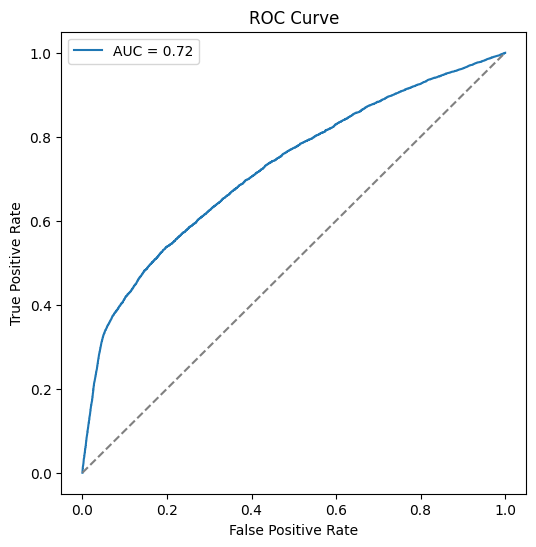

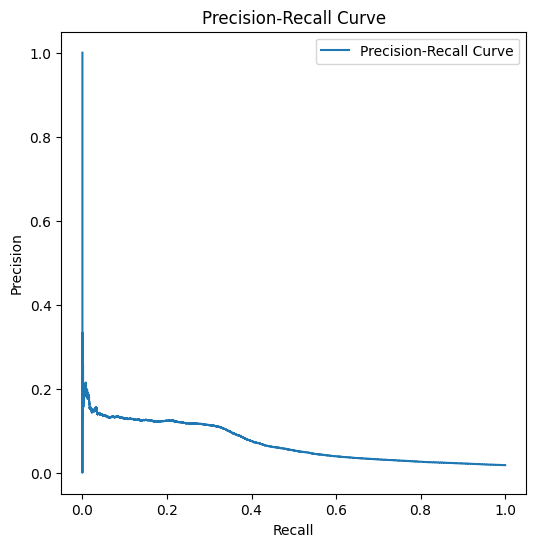

<Figure size 600x600 with 0 Axes>

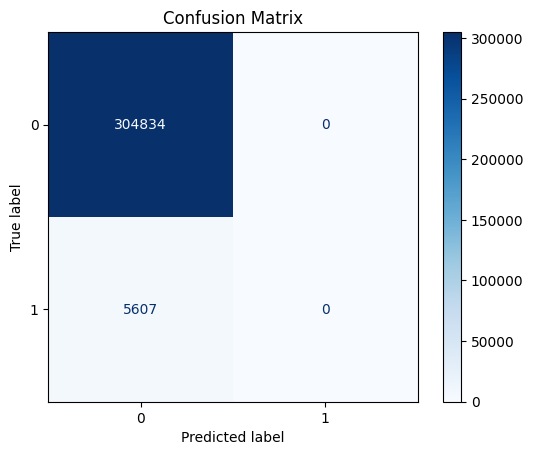

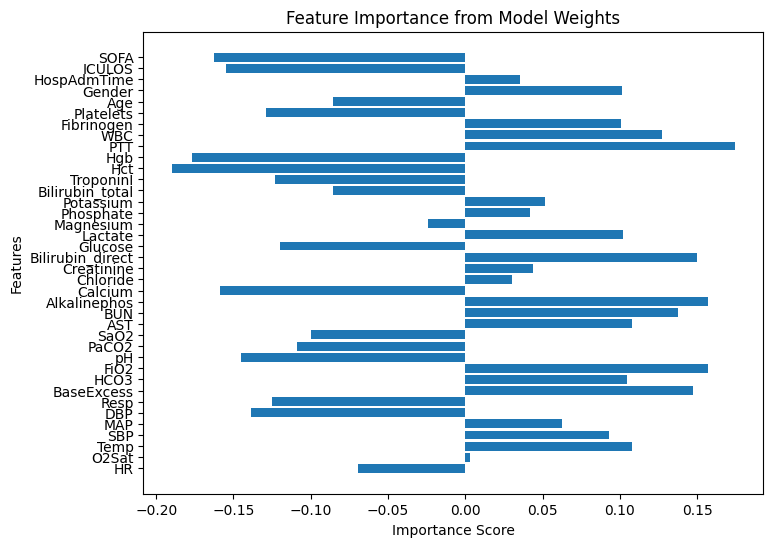

In [17]:

y_test = df['y_test'].values
y_probs = df['y_probs'].values
y_pred = df['y_pred'].values

plot_roc_curve(y_test, y_probs)
plot_precision_recall_curve(y_test, y_probs)
plot_confusion_matrix(y_test, y_pred)
plot_feature_importance(model, feature_names)